In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# data load
import os
import sys
import torch
from sklearn.model_selection import train_test_split

ROOT_DIR = "/data/tyler_dev/working_dir/sym/symptom_similarity"
DATA_DIR = os.path.join(ROOT_DIR, "data")
sys.path.append(ROOT_DIR)
from core.io_ops import load_pickle
from core.data_model import Patients
from core.augmentation import cleanse_data

disease_data = load_pickle(os.path.join(DATA_DIR, "diseases.pickle"))
patient_data = load_pickle(os.path.join(DATA_DIR, "patients.pickle"))
disease_data, patient_data = cleanse_data(disease_data, patient_data)
all_symptom_vectors = torch.tensor(
    disease_data.all_symptom_vectors, dtype=torch.float32
)

train_val_patients_list, test_patients_list = train_test_split(
    patient_data.data, random_state=2023
)
train_patients_list, val_patients_list = train_test_split(
    train_val_patients_list, random_state=2023
)
train_patients = Patients(train_patients_list)
val_patients = Patients(val_patients_list)
test_patients = Patients(test_patients_list)

### 최근 연구


In [ ]:
import json
with open("/data/tyler_dev/working_dir/sym/lin_similarity_matrix.json", "r") as f:
    similarity_matrix = json.load(f)

In [ ]:
# 식 참고해서 계산
# t in P, t` in D
# s_p = sum_p(max_d(sim(t, t`))*IC(t)) / sum(IC(t))
# s_pd = (sum_p(max_d(sim(t, t`))*IC(t)) + sum_d(max_p(sim(t, t`))*IC(t`))) /  (sum(IC(t)) + sum(IC(t`)))


def get_sym(patient, disease):
    sum_sym = 0.
    sum_ic = 0.
    for p_sym in patient.hpos:
        max_sim = 0.
        for d_sym in disease.hpos:
            try:
                score = similarity_matrix[p_sym.id][d_sym.id] 
            except:
                score = 0 
                
            if score > max_sim:
                max_sim = score

        sum_sym += max_sim * p_sym.ic
        sum_ic += p_sym.ic
    
    return sum_sym, sum_ic


def get_pheno2disease(patient, disease):
    sum_sym_p, sum_ic_p = get_sym(patient, disease)
    sum_sym_d, sum_ic_d = get_sym(disease, patient)
    sym_pd = (sum_sym_p+sum_sym_d) / (sum_ic_p + sum_ic_d)

    pheno2disease = sym_pd + (sum_sym_p/sum_ic_p)

    return pheno2disease


### model based

In [ ]:
from core.datasets import (
    StochasticPairwiseDataset,
    collate_for_stochastic_pairwise_eval,
)
from torch.utils.data import DataLoader

# 현재 최고 모델
from core.networks import Transformer

params = {
    "output_size": 128,
    "hidden_dim": 2048,
    "input_size": 1536,
    "n_layers": 32,
    "nhead": 32,
    "batch_first": False,
}
best_model = Transformer(**params)
best_model.load_state_dict(
    torch.load(
        "/data/tyler_dev/working_dir/sym/symptom_similarity/data/81fcf4f39e57422db4debfeac61b01f0/val_top100_0.584.ckpt"
    )
)
best_model.eval()
best_model = best_model.cuda()

test_dataset = StochasticPairwiseDataset(
    test_patients,
    disease_data,
    max_len=15,
).validate()

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=0,
    collate_fn=collate_for_stochastic_pairwise_eval,
    shuffle=False,
    pin_memory=True,
)

/data/tyler_dev/anaconda3/envs/sym_sim_gu/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from core_3asc.metric import topk_recall


cached_vector = {}
whole_disease = test_dataset.disease_tensors
with torch.no_grad():
    with tqdm(
        total=len(whole_disease),
        position=0,
        leave=True,
        desc="Making all disease vectors...",
    ) as pbar:
        for id_, tensor in whole_disease.items():
            cached_vector[id_] = best_model(tensor.cuda()).squeeze(0)
            pbar.update(1)

Making all disease vectors...: 100%|██████████| 8181/8181 [02:03<00:00, 66.34it/s]


In [ ]:
from core.augmentation import (
    TruncateOrPad,
)

padder = TruncateOrPad(
            15, stochastic=False, weighted_sampling=True
        )

def get_score_from_model(patient, disease):
    with torch.no_grad():
        input_src = padder(
            torch.tensor(patient.hpos.vector, dtype=torch.float32, device="cuda:0"), patient
        )

        input_vector = best_model(input_src)
        target_vector = cached_vector[disease.id]
        scores = (
            torch.nn.functional.cosine_similarity(
                input_vector, target_vector
            )
            .squeeze(-1)
            .detach()
            .cpu()
            .numpy()
        )

        del input_src
        del input_vector
        torch.cuda.empty_cache()

        return scores

def get_att_weight(disease):
    with torch.no_grad():
        input_src = padder(
            torch.tensor(disease.hpos.vector, dtype=torch.float32).cuda(), disease
        )
        return best_model.get_att_weight(input_src)

### 사내 시스템

In [ ]:
from omegaconf import OmegaConf
from SemanticSimilarity.calculator import NodeLevelSimilarityCalculator

conf = OmegaConf.load("/data/tyler_dev/working_dir/sym/SemanticSimilarity/config.yaml")
# 원본 알고리즘 이용한 계산
tb_cal = NodeLevelSimilarityCalculator(conf)
tb_cal.set_level()
tb_cal.set_mica_mat()

/data/tyler_dev/working_dir/sym/SemanticSimilarity/calculator.py:102: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  self.hpo_ontology = pronto.Ontology(


In [ ]:
from SemanticSimilarity.data_model import Phenotype

def calculate_score(p, d):
    node_level = {}
    node_level[p.id] = {}
    p_syms = {Phenotype(id_, name) for id_, name in zip(p.hpos.id2hpo.keys(), p.hpos.name2hpo.keys())}
    d_syms = {Phenotype(id_, name) for id_, name in zip(d.hpos.id2hpo.keys(), d.hpos.name2hpo.keys())}
    score = tb_cal.get_semantic_similarity(p_syms, d_syms)
    return score

### 비교평가

In [ ]:
np.random.seed(42)

# 사내 기진단 환자에서 랜덤하게 평가 대상을 샘플링
n_patients = 300
p_samples = np.random.choice(range(len(test_dataloader)), n_patients).tolist()

In [ ]:
# 사내 기진단 환자에서 진단 빈도가 상위인 질병을 샘플링  
n_top_confirmed_disease = 500

cnt_disease = defaultdict(int)
for p_data in patient_data:
    for d in list(p_data.disease_ids):
        cnt_disease[d] += 1

sorted_dict_desc = dict(sorted(cnt_disease.items(), key=lambda item: item[1], reverse=True))
d_samples = list(sorted_dict_desc.keys())[:n_top_confirmed_disease]

In [ ]:
"""
질병 데이터와 환자 데이터 중 쓸 수 없는 데이터를 아래의 기준으로 필터링

- 질병 데이터
    - OMIM이 아닌(ORPHA)등의 id를 가진 증상을 하나라도 가질 경우 

- 환자 데이터
    - 아래의 네가지 조건을 기준으로 필터링

        - zero_symptom: 기록된 증상이 하나도 없는 경우
        - too_many_symptom: 기록된 증상이 50개를 초과하는 경우 (가끔 매우 많이 들어오는 환자가 있어요)
        - disease_id_missing: 기록된 진단 질병명이 없는 경우 
        - not_in_hpo_db: [HPO_VERSION = "v2023-10-09"]에서 포함되지 않는 증상이 있는 경우
"""
disease_data_sample, patient_data_sample = cleanse_data(disease_data[d_samples], patient_data[p_samples])

In [ ]:
# 해당 함수는 3asc에서 사용하던 평가 방식인데요,
# 추천시스템 분야에서 자주쓰이는 평가방식이고
# 해당분야에서는 "Hit@k"로 불립니다.(검색하려면 해당 키워드로 접급해야되요, cf.recall@k) 
 
from core_3asc.metric import topk_recall


result = []
for p in tqdm(patient_data_sample):
    onehot_vec = np.zeros((len(disease_data_sample), ))
    
    scores_base = np.zeros((len(disease_data_sample), ))
    scores_pd = np.zeros((len(disease_data_sample), ))
    scores_model = np.zeros((len(disease_data_sample), ))


    for i, d in enumerate(disease_data_sample):
        if d.id in p.disease_ids:
            onehot_vec[i] = 1

        scores_base[i] = calculate_score(p, d)
        scores_pd[i] = get_pheno2disease(p, d)
        scores_model[i] = get_score_from_model(p, d)
    
    result.append({
        "p_id": p.id, 
        "scores_base": scores_base, 
        "scores_pd": scores_pd, 
        "scores_model": scores_model, 

       "top_1_base": topk_recall(scores_base, onehot_vec, k=1),
        "top_1_pd": topk_recall(scores_pd, onehot_vec, k=1),
        "top_1_model": topk_recall(scores_model, onehot_vec, k=1),

        "top_10_base": topk_recall(scores_base, onehot_vec, k=10),
        "top_10_pd": topk_recall(scores_pd, onehot_vec, k=10),
        "top_10_model": topk_recall(scores_model, onehot_vec, k=10),

        "top_50_base": topk_recall(scores_base, onehot_vec, k=50),
        "top_50_pd": topk_recall(scores_pd, onehot_vec, k=50),
        "top_50_model": topk_recall(scores_model, onehot_vec, k=50),

        "top_100_base": topk_recall(scores_base, onehot_vec, k=100),
        "top_100_pd": topk_recall(scores_pd, onehot_vec, k=100),
        "top_100_model": topk_recall(scores_model, onehot_vec, k=100),
        
    })

In [ ]:
import pandas as pd
result_df = pd.DataFrame(result)
result_df = result_df.set_index("p_id")
result_df = result_df[list(set(result_df.columns) - {'p_id', 'scores_base', 'scores_pd', 'scores_model'})]

data = (result_df.sum(0) / len(result_df)).to_dict()


# Initialize empty dictionaries for 'base', 'pd', and 'model' data
base_data = {'top1': None, 'top10': None, 'top50': None, 'top100': None}
pd_data = {'top1': None, 'top10': None, 'top50': None, 'top100': None}
model_data = {'top1': None, 'top10': None, 'top50': None, 'top100': None}

# Organize the data according to 'base', 'pd', and 'model' categories
for key, value in data.items():
    if 'base' in key:
        base_data[f"top{key.split('_')[1]}"] = value
    elif 'pd' in key:
        pd_data[f"top{key.split('_')[1]}"] = value
    elif 'model' in key:
        model_data[f"top{key.split('_')[1]}"] = value

# Create a DataFrame with 'base', 'pd', and 'model' as rows and 'top1', 'top10', 'top50', 'top100' as columns
df = pd.DataFrame([base_data, pd_data, model_data], index=['baseline', 'Pheno2Disease', 'LLM-based'])
df.index.name = 'Method'

# Display the DataFrame
print(df)

                   top1     top10     top50    top100
Method                                               
baseline       0.117647  0.486631  0.754011  0.871658
Pheno2Disease  0.117647  0.427807  0.721925  0.834225
LLM-based      0.219251  0.513369  0.855615  0.919786


In [ ]:
'''
               top1     top10     top50    top100
Method                                               
baseline       0.117647  0.486631  0.754011  0.871658
Pheno2Disease  0.117647  0.427807  0.721925  0.834225
LLM-based      0.219251  0.513369  0.855615  0.919786
'''

### case review

In [ ]:
# 증상 적은 케이스(1개): 정답 질병의 순위
# 증상 많은 케이스 (극단적으로 많은): 정답 질병의 순위

/data/tyler_dev/working_dir/sym/SemanticSimilarity/calculator.py:102: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  self.hpo_ontology = pronto.Ontology(


### failed samples

In [ ]:
# failed sample에서 insight

top_100_failed_samples = test_patients[fails[100]]
top_100_success_samples = test_patients[ [i for i in range(len(test_patients)) if i not in fails[100]]]

In [ ]:
num_fail_symps = []
for p in top_100_failed_samples:
    num_fail_symps.append(len(p.hpos))

num_success_symps = []
for p in top_100_success_samples:
    num_success_symps.append(len(p.hpos))

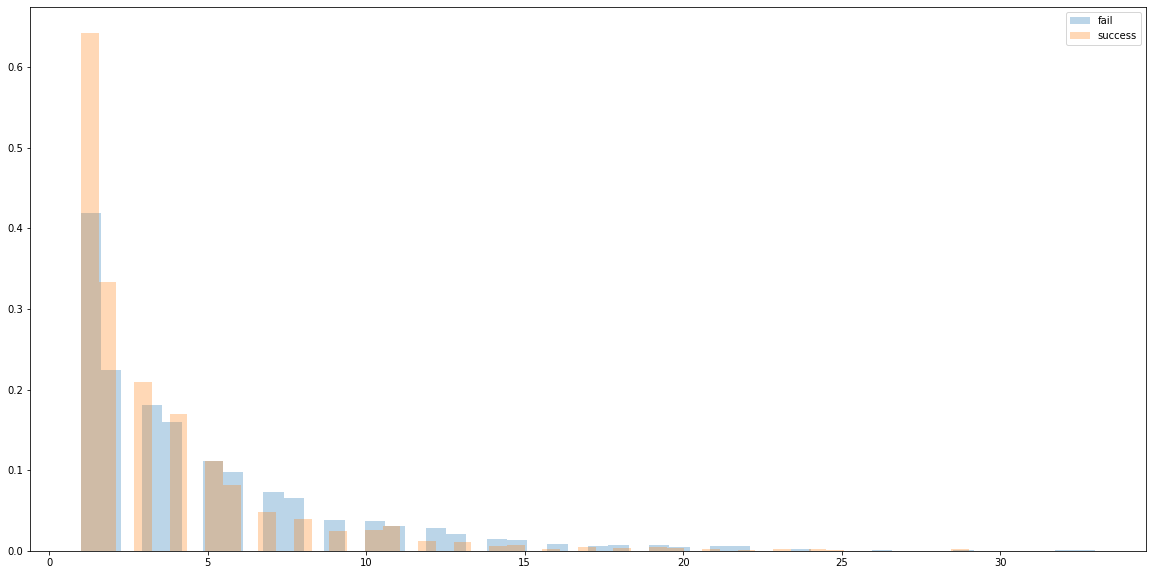

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.hist(num_fail_symps, bins=50, alpha=0.3, density=True)
plt.hist(num_success_symps, bins=50, alpha=0.3, density=True)
plt.legend(["fail", "success"])
plt.show()

### att weight 분석

In [ ]:
# 주증상, 부증상 성공 사례 보이기
idx= 8
print(disease_data[idx].name)


weights = get_att_weight(disease_data[idx])
weights = torch.cat(weights)
# layer, head, n
## 참고: https://github.com/4pygmalion/LaRa/issues/2#issuecomment-1975012658
weight_mean = weights.mean(0).mean(0).mean(0)

combined = zip(list(disease_data[idx].hpos.name2hpo.keys()), weight_mean)
sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)

sorted_combined

Charcot-Marie-Tooth disease, type 4B2


[('Onion bulb formation', tensor(0.0672, device='cuda:0')),
 ('Hyporeflexia', tensor(0.0672, device='cuda:0')),
 ('Kyphoscoliosis', tensor(0.0671, device='cuda:0')),
 ('Areflexia', tensor(0.0670, device='cuda:0')),
 ('Decreased motor nerve conduction velocity',
  tensor(0.0670, device='cuda:0')),
 ('Segmental peripheral demyelination/remyelination',
  tensor(0.0668, device='cuda:0')),
 ('Pes cavus', tensor(0.0668, device='cuda:0')),
 ('Split hand', tensor(0.0667, device='cuda:0')),
 ('Difficulty walking', tensor(0.0665, device='cuda:0')),
 ('Talipes equinovarus', tensor(0.0665, device='cuda:0')),
 ('Steppage gait', tensor(0.0665, device='cuda:0')),
 ('Juvenile onset', tensor(0.0662, device='cuda:0')),
 ('Distal amyotrophy', tensor(0.0662, device='cuda:0')),
 ('Distal muscle weakness', tensor(0.0662, device='cuda:0')),
 ('Ulnar claw', tensor(0.0661, device='cuda:0'))]

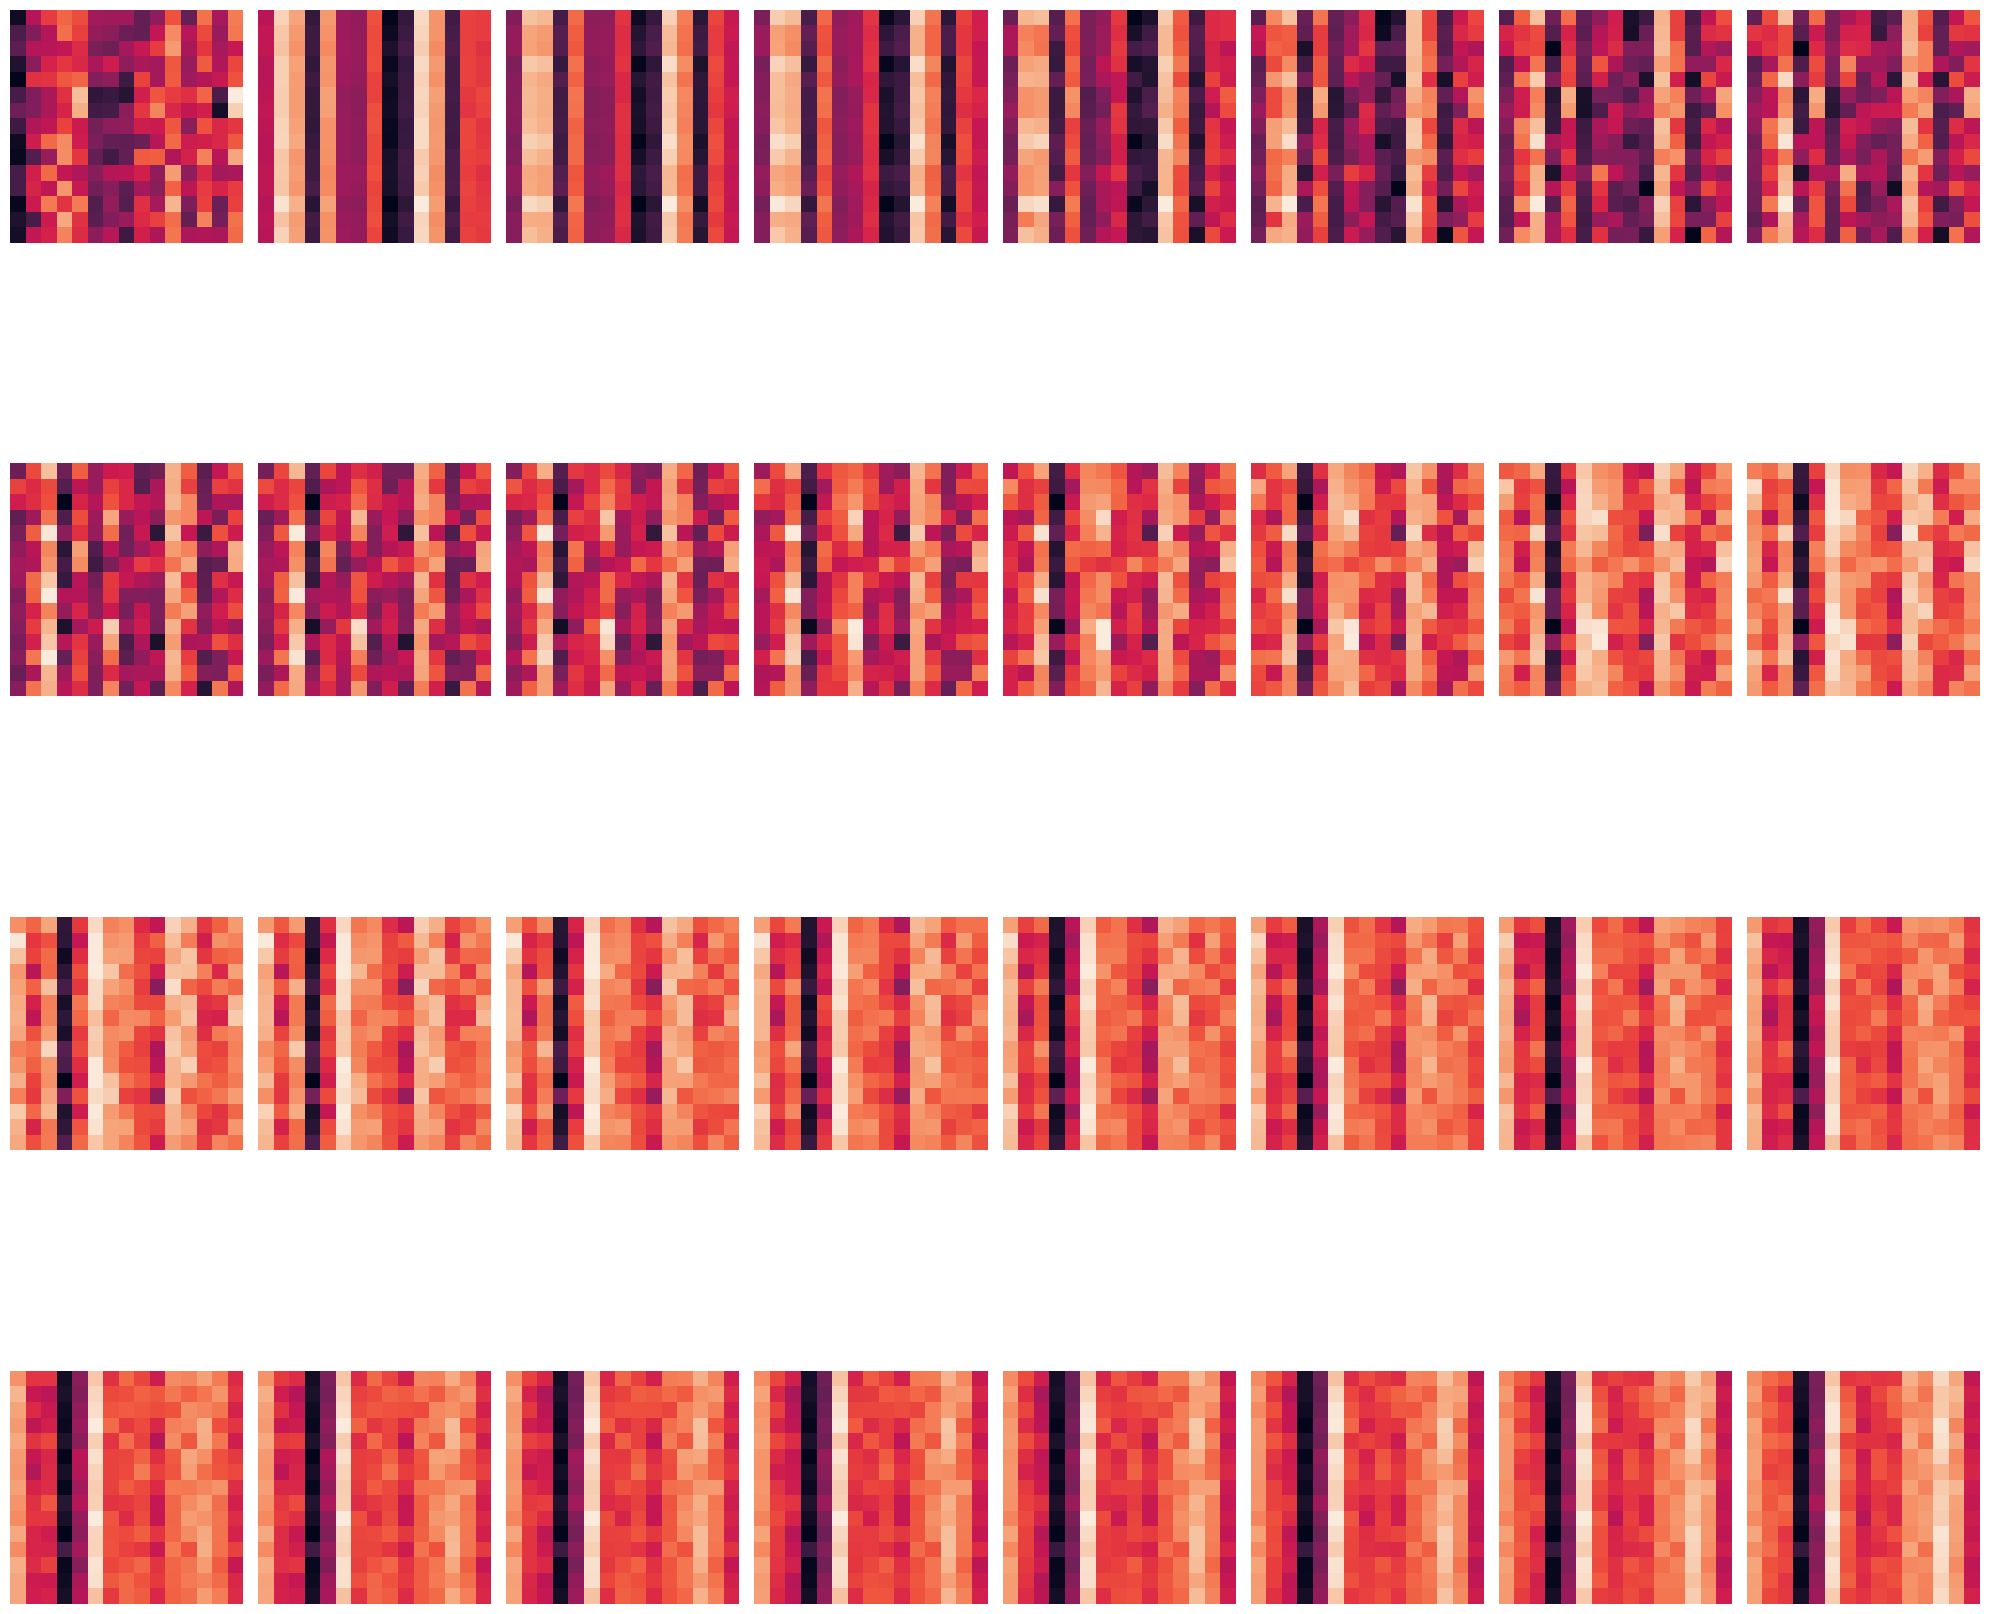

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# layer별 att weight  

N = 4 
M = 8  

plt.figure(figsize=(20, 20))

for i in range(N * M):
    plt.subplot(N, M, i + 1)
    sns.heatmap(weights.cpu().mean(1)[i], square=True, cbar=False)  # Added square and removed color bar for better aesthetics
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()